<a href="https://colab.research.google.com/github/SylviaaaaW/StyleCLIP_study/blob/main/StyleCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# セットアップ

In [1]:
%tensorflow_version 1.x
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! git clone https://github.com/SylviaaaaW/StyleCLIP_study.git

TensorFlow 1.x selected.
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.3 MB/s eta 0:04:15tcmalloc: large alloc 1147494400 bytes == 0x558fe37f0000 @  0x7fed146fe615 0x558faaa844cc 0x558faab6447a 0x558faaa872ed 0x558faab78e1d 0x558faaafae99 0x558faaaf59ee 0x558faaa88bda 0x558faaafad00 0x558faaaf59ee 0x558faaa88bda 0x558faaaf7737 0x558faab79c66 0x558faaaf6daf 0x558faab79c66 0x558faaaf6daf 0x558faab79c66 0x558faaaf6daf 0x558faaa89039 0x558faaacc409 0x558faaa87c52 0x558faaafac25 0x558faaaf59ee 0x558faaa88bda 0x558faaaf7737 0x558faaaf59ee 0x558faaa88bda 0x558faaaf6915 0x558faaa88afa 0x558faaaf6c0d 0x558faaaf59ee
     |█████████████████████████████▏  | 1055.7 MB 1.2 MB/s eta 0:01:25tcmalloc: large alloc 1434370048 bytes == 0x559027e46000 @  0x7fed146fe615 0x558faaa844cc 0x558faab6447a 0x558faaa872ed 0x558faab78e1d 0x558faaafae99 0x558faaaf59ee 0x558faaa88bda 0x558faaafad00 0x558faaaf59ee 0x558faaa88bda 0x558faaaf7737 0x

In [2]:
#from tensorflow.python.client import device_lib
#print(device_lib.list_local_devices())

In [3]:
# input dataset name 
dataset_name='ffhq' # input dataset name, currently, only support ffhq

% cd StyleCLIP_study/global/

# input prepare data 
!python GetCode.py --dataset_name $dataset_name --code_type 'w'
!python GetCode.py --dataset_name $dataset_name --code_type 's'
!python GetCode.py --dataset_name $dataset_name --code_type 's_mean_std'

import tensorflow as tf
import numpy as np 
import torch
import clip
from PIL import Image
import pickle
import copy
import matplotlib.pyplot as plt
from MapTS import GetFs,GetBoundary,GetDt
from manipulate import Manipulator
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

M=Manipulator(dataset_name='ffhq')
fs3=np.load('./npy/ffhq/fs3.npy')
np.set_printoptions(suppress=True)

/content/StyleCLIP_study/global
--2021-10-27 18:53:40--  https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-ffhq-config-f.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 99.86.38.69, 99.86.38.102, 99.86.38.107, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|99.86.38.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381673535 (364M) [application/x-www-form-urlencoded]
Saving to: ‘./model/stylegan2-ffhq-config-f.pkl’

stylegan2-ffhq-conf 100%[===================>] 363.99M   178MB/s    in 2.0s    

2021-10-27 18:53:43 (178 MB/s) - ‘./model/stylegan2-ffhq-config-f.pkl’ saved [381673535/381673535]

Setting up TensorFlow plugin "fused_bias_act.cu": Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Compiling... Loading... Done.
get all z and w
Generate S
2021-10-27 18:54:29.823852: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcud

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 56.3MiB/s]


Setting up TensorFlow plugin "fused_bias_act.cu": Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Loading... Done.

Gs                              Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/Normalize             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping/Dense1                262656    (?, 512)             (512, 512)      
G_mapping/Dense2                262656    (?, 512)             (512, 512)      
G_mapping/Dense3                262656    (?, 512)             (512, 

# 画像編集

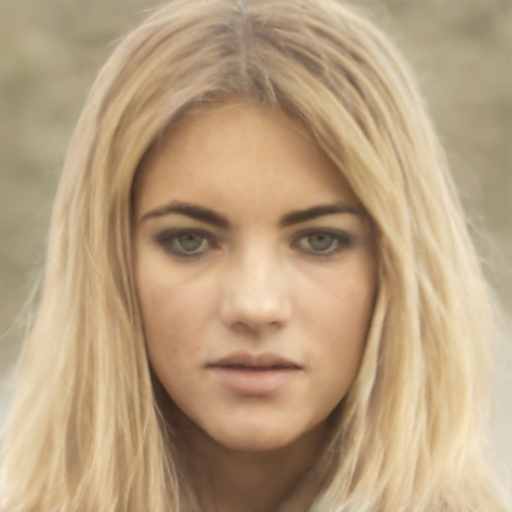

In [16]:
# --- 画像の選択 ---

pt_folder = 'vec/'
pt_name = '000019.pt' #@param {type:"string"}
latents=torch.load(pt_folder+pt_name)
w_plus=latents.cpu().detach().numpy()
M.dlatents=M.W2S(w_plus)

img_indexs=[0]
dlatent_tmp=[tmp[img_indexs] for tmp in M.dlatents]
M.num_images=len(img_indexs)

M.alpha_A=[0]
M.alpha_B=[0]
M.manipulate_layers=[0]
codes,out=M.EditOneC(0,dlatent_tmp) 
original=Image.fromarray(out[0,0]).resize((512,512))
M.manipulate_layers=None
original



In [17]:
# --- テキスト入力A ---

neutral_A='face' #@param {type:"string"}
target_A='smiling face' #@param {type:"string"}
classnames_A=[target_A,neutral_A]
dt_A=GetDt(classnames_A,model)

0.364


In [18]:
# --- テキスト入力B ---

neutral_B='face' #@param {type:"string"}
target_B='mad face' #@param {type:"string"}
classnames_B=[target_B,neutral_B]
dt_B=GetDt(classnames_B,model)

0.3042


(-0.5, 1023.5, 1023.5, -0.5)

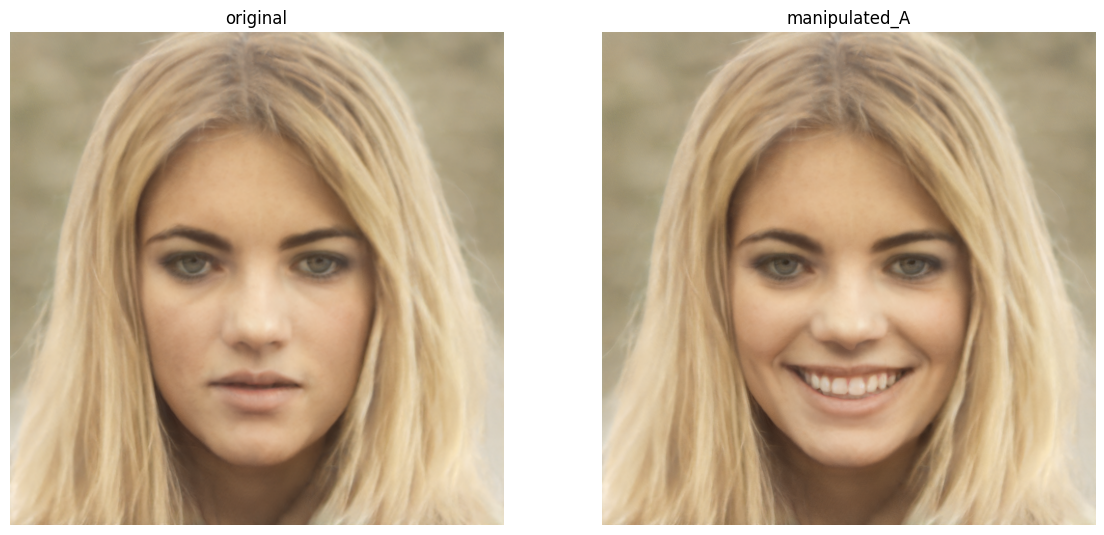

In [19]:
# --- alpha & beta Aの設定 ---

beta_A = 0.1 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha_A = 2.5 #@param {type:"slider", min:-10, max:10, step:0.1}
M.alpha=[alpha_A]
boundary_tmp2,c=GetBoundary(fs3,dt_A,M,threshold=beta_A)
codes=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes)
generated=Image.fromarray(out[0,0])#.resize((512,512))

plt.figure(figsize=(14,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(original)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated)
plt.title('manipulated_A')
plt.axis('off')

(-0.5, 1023.5, 1023.5, -0.5)

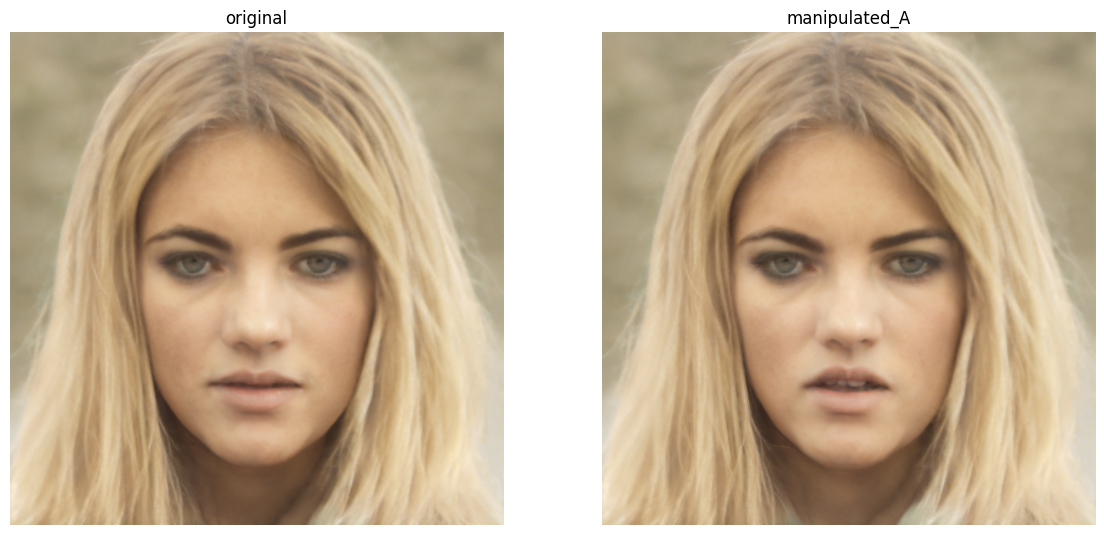

In [20]:
# --- alpha & beta Bの設定 ---

beta_B = 0.1 #@param {type:"slider", min:0.08, max:0.3, step:0.01}
alpha_B = 2.5 #@param {type:"slider", min:-10, max:10, step:0.1}
M.alpha=[alpha_B]
boundary_tmp2,c=GetBoundary(fs3,dt_B,M,threshold=beta_B)
codes=M.MSCode(dlatent_tmp,boundary_tmp2)
out=M.GenerateImg(codes)
generated=Image.fromarray(out[0,0])#.resize((512,512))

plt.figure(figsize=(14,7), dpi= 100)
plt.subplot(1,2,1)
plt.imshow(original)
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(generated)
plt.title('manipulated_A')
plt.axis('off')

In [24]:
# ---二つtarget 編集画像の連続生成 ---

alpha_A = 2.5 #@param {type:"slider", min:-10, max:10, step:0.1}
alpha_B = 2.5 #@param {type:"slider", min:-10, max:10, step:0.1}
numA = int(alpha_A*10)
numB = int(alpha_B*10)
beta = 0.1

from tqdm import trange
import os
import shutil

# pic フォルダーリセット
if os.path.isdir('pic'):
     shutil.rmtree('pic')
os.makedirs('pic', exist_ok=True)

# 画像生成関数 表情A
def generate_img_A(alpha, cnt):
     M.alpha=[alpha]
     boundary_tmp2,c=GetBoundary(fs3,dt_A,M,threshold=beta)
     codes=M.MSCode(dlatent_tmp,boundary_tmp2)
     out=M.GenerateImg(codes)
     pic = Image.fromarray(out[0,0])
     pic = pic.resize((512,512))  

     # orjinal と連結
     dst = Image.new('RGB', (original.width + pic.width, original.height))
     dst.paste(original, (0,0))
     dst.paste(pic, (original.width, 0))

     dst.save('./pic/'+str(cnt).zfill(6)+'.png') 

# 画像生成関数　表情B
def generate_img_B(alpha, cnt):
     M.alpha=[alpha]
     boundary_tmp2,c=GetBoundary(fs3,dt_B,M,threshold=beta)
     codes=M.MSCode(dlatent_tmp,boundary_tmp2)
     out=M.GenerateImg(codes)
     pic = Image.fromarray(out[0,0])
     pic = pic.resize((512,512))  

     # orjinal と連結
     dst = Image.new('RGB', (original.width + pic.width, original.height))
     dst.paste(original, (0,0))
     dst.paste(pic, (original.width, 0))

     dst.save('./pic/'+str(cnt).zfill(6)+'.png')     

cnt = 0
for i in trange(15, desc='alpha = 0'):
     generate_img_A(0, cnt)
     cnt +=1

for i in trange(0, numA, 1, desc='alpha_A = 0 -> max'):
     generate_img_A(i/10, cnt)
     cnt +=1

for i in trange(0, numA, 1, desc='alpha_A =max -> 0'):
     generate_img_A((numA-i)/10, cnt)
     cnt +=1

#for i in trange(2, desc='alpha = 0'):
#     generate_img_B(0, cnt)
#     cnt +=1

for i in trange(60, desc='alpha_B = 0 -> max'):
     generate_img_B(i/10, cnt)
     cnt +=1

for i in trange(0, numB, 1, desc='alpha_B = max -> 0'):
     generate_img_B((numB-i)/10, cnt)
     cnt +=1

alpha_B = max -> 0: 100%|██████████| 25/25 [00:09<00:00,  2.71it/s]


In [25]:
# --- mp4動画の作成 ---

# 既に output.mp4 があれば削除する
import os
if os.path.exists('./output.mp4'):
   os.remove('./output.mp4')

# pic フォルダの画像から動画を生成
! ffmpeg -r 30 -i pic/%6d.png\
               -vcodec libx264 -pix_fmt yuv420p output.mp4

# movieフォルダへ名前を付けてコピー
import shutil
os.makedirs('movie', exist_ok=True)
shutil.copy('output.mp4', 'movie/'+target_B+'_'+pt_name[:-3]+'.mp4')

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

'movie/mad face_000019.mp4'

In [26]:
# --- mp4動画の再生 ---

from IPython.display import HTML
from base64 import b64encode

mp4 = open('./output.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="70%" height="70%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")